In [3]:
import geopandas as gpd
import geoplot as gplt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import Affine
from scipy import stats
from shapely.geometry import Polygon, box
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity
import pymysql.cursors
import rtree


In [4]:
connection = pymysql.connect(host='127.0.0.1',
						port=3306,
						user='root',
						password='vagrant',
						db='python_fcc_db_test',
						charset='utf8mb4',
						cursorclass=pymysql.cursors.DictCursor,
						autocommit=True)

cursor = connection.cursor()


# Identify CME data center

In [54]:
sql = """
        select
            en.call_sign as callsign,
            st_x(tlo.lat_long_point) as lon_decimal,
            st_y(tlo.lat_long_point) as lat_decimal
            from 
                entities_of_interest as en,
                mmw_paths as mp,
                mmw_location as tlo
            where 
                en.call_sign = mp.callsign
                and tlo.call_sign = mp.callsign
                and tlo.location_number = mp.transmit_location_number
                and tlo.lat_long_point IS NOT NULL
                and st_x(tlo.lat_long_point) > -88.516840
                and st_x(tlo.lat_long_point) < -88.003229
                and st_y(tlo.lat_long_point) > 41.6152392
                and st_y(tlo.lat_long_point) < 41.9122953
            limit 10000000
        """
            
cursor.execute(sql)
results = cursor.fetchall()

array = []

for result in results:
    array.append([result['callsign'], result['lat_decimal'], result['lon_decimal']])

df = pd.DataFrame(array, columns=['callsign', 'lat', 'lon'])
links = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4269")
links = links.to_crs("EPSG:3857")
print(links.head())

  callsign        lat        lon                          geometry
0  WQNH795  41.798861 -88.114000  POINT (-9808805.612 5130897.271)
1  WQNH795  41.798861 -88.114000  POINT (-9808805.612 5130897.271)
2  WQNH795  41.798861 -88.114000  POINT (-9808805.612 5130897.271)
3  WQNH795  41.798806 -88.113889  POINT (-9808793.243 5130888.975)
4  WQNH795  41.798806 -88.113889  POINT (-9808793.243 5130888.975)


In [74]:
# State boundaries 
# from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

states = gpd.read_file("../data/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
states = states.to_crs("EPSG:3857")
print(states.crs)
proj = "EPSG:3857"

il_counties = gpd.read_file("../data/IL_BNDY_County/IL_BNDY_County_Py.shp")
il_counties = il_counties.to_crs(proj)
print(il_counties.head())

EPSG:3857
  COUNTY_NAM  CO_FIPS                                           geometry
0    MCHENRY      111  POLYGON ((-9874864.657 5235194.229, -9872712.7...
1      BOONE        7  POLYGON ((-9874864.657 5235194.229, -9874862.8...
2       OGLE      141  POLYGON ((-9984031.251 5190909.694, -9981847.4...
3       WILL      197  POLYGON ((-9825220.417 5119782.857, -9825221.2...
4    LASALLE       99  POLYGON ((-9900627.215 5105470.928, -9900611.4...


In [64]:
def create_grid(feature, shape, side_length):
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(500)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))


    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = proj)

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

In [13]:
# Set side length for cells in grid
# This is dependent on projection chosen as length is in units specified in projection
side_length = 1000

# Set shape of grid
#shape = "hexagon"
shape = "rectangle"

Text(0.5, 1.0, 'United States Links')

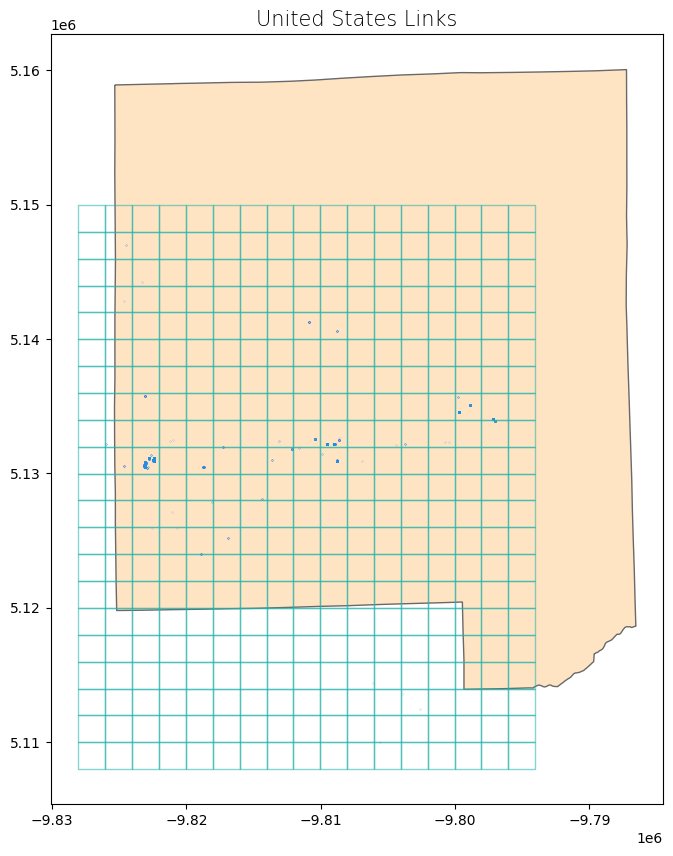

In [87]:
# Create grid
united_states_grid = create_grid(feature = links, shape = shape, side_length = side_length)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
#mainland = ['Wisconsin', 'Illinois', "Indiana", "Kentucky", "Ohio", "Michigan", "West Virginia", "Pennsylvania", "Virginia", "New Jersey", "New York"]

#mainland_usa = states.query('NAME in @mainland')
#mainland_usa.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')

near_aurora_counties = ['DUPAGE']
near_aurora = il_counties.query('COUNTY_NAM in @near_aurora_counties')
near_aurora.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')

links.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = .001)
united_states_grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.55)

# Set title
ax.set_title('United States Links', fontdict = {'fontsize': '15', 'fontweight' : '3'})

Text(0.5, 1.0, 'US Grid Link Frequency')

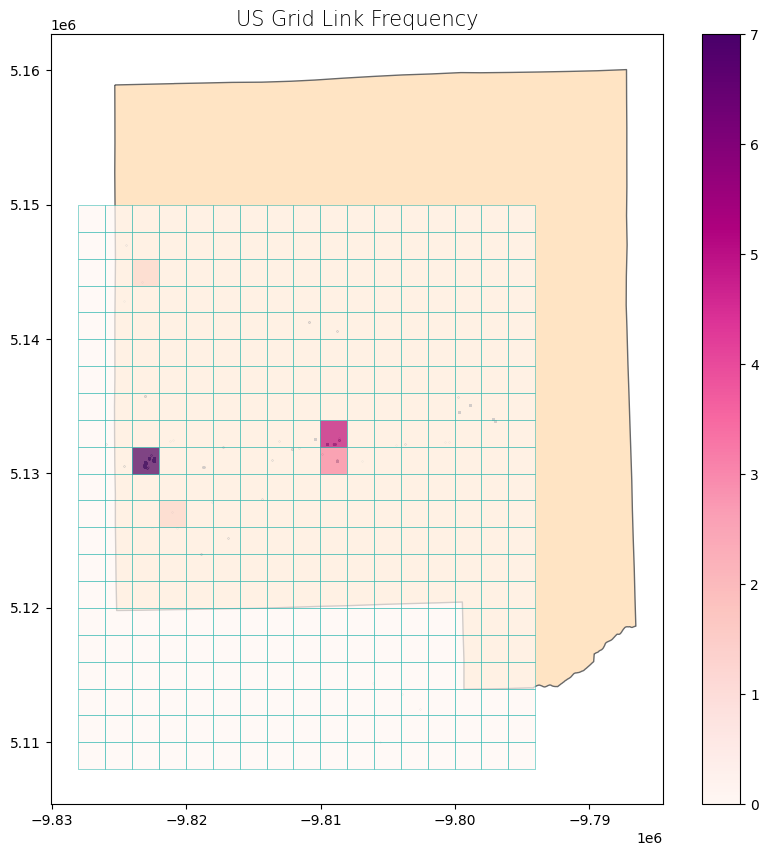

In [89]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
#not_mainland = ["Illinois"]
#mainland_usa = states.query('NAME in @not_mainland')
#mainland_usa.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
near_aurora.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
links.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = .001)
us_grid.plot(ax = ax, column = "Count", cmap = "RdPu", edgecolor = 'lightseagreen', linewidth = 0.5, alpha = 0.70, legend = True)

# Set title
ax.set_title('US Grid Link Frequency', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [96]:
important = us_grid[us_grid['Count'] > 5]['geometry'].iloc[0]
print(important)
print(important.centroid)

POLYGON ((-9822030.657428011 5129969.848459163, -9822030.657428011 5131969.848459163, -9824030.657428011 5131969.848459163, -9824030.657428011 5129969.848459163, -9822030.657428011 5129969.848459163))
POINT (-9823030.657428011 5130969.848459163)


# Identify NYSE data centers

In [71]:
sql = """
        select
            en.call_sign as callsign,
            st_x(tlo.lat_long_point) as lon_decimal,
            st_y(tlo.lat_long_point) as lat_decimal
            from 
                entities as en,
                mmw_paths as mp,
                mmw_location as tlo
            where 
                en.call_sign = mp.callsign
                and tlo.call_sign = mp.callsign
                and tlo.location_number = mp.transmit_location_number
                and tlo.lat_long_point IS NOT NULL
                and st_x(tlo.lat_long_point) > -74.70051
                and st_x(tlo.lat_long_point) < -73.73082
                and st_y(tlo.lat_long_point) > 40.427139
                and st_y(tlo.lat_long_point) < 41.127705
            limit 10000000
        """
            
cursor.execute(sql)
results = cursor.fetchall()

array = []

for result in results:
    array.append([result['callsign'], result['lat_decimal'], result['lon_decimal']])

df_nj = pd.DataFrame(array, columns=['callsign', 'lat', 'lon'])
links_nj = gpd.GeoDataFrame(df_nj, geometry=gpd.points_from_xy(df_nj.lon, df_nj.lat), crs="EPSG:4269")
links_nj = links_nj.to_crs("EPSG:3857")
print(links_nj.head())

  callsign        lat        lon                          geometry
0  WQEZ616  40.629250 -74.319028  POINT (-8273156.328 4957808.973)
1  WQEZ616  40.628278 -74.320917  POINT (-8273366.599 4957666.370)
2  WQEZ616  40.717444 -74.012278  POINT (-8239009.075 4970753.694)
3  WQEZ616  40.714556 -74.011167  POINT (-8238885.386 4970329.406)
4  WQEZ616  40.714556 -74.011167  POINT (-8238885.386 4970329.406)


In [72]:
proj = "EPSG:3857"


nj_counties = gpd.read_file("../data/County_Boundaries_of_NJ/County_Boundaries_of_NJ.shp")
nj_counties = nj_counties.to_crs(proj)
print(nj_counties.head())

   OBJECTID      COUNTY         COUNTY_LAB   CO             GNIS_NAME    GNIS  \
0         1    ATLANTIC    Atlantic County  ATL    County of Atlantic  882270   
1         2      BERGEN      Bergen County  BER      County of Bergen  882271   
2         3  BURLINGTON  Burlington County  BUR  County of Burlington  882272   
3         4      CAMDEN      Camden County  CAM      County of Camden  882273   
4         5    CAPE MAY    Cape May County  CAP    County of Cape May  882274   

  FIPSSTCO FIPSCO          ACRES    SQ_MILES  ...  POPDEN2000  POPDEN1990  \
0    34001      1  390813.840968  610.646627  ...         414         451   
1    34003      3  153489.661221  239.827596  ...        3686        3459   
2    34005      5  524901.239973  820.158187  ...         516         482   
3    34007      7  145597.905686  227.496728  ...        2237        2341   
4    34009      9  183125.841721  286.134128  ...         358         332   

   POPDEN1980        REGION                       

Text(0.5, 1.0, 'New Jersey Links')

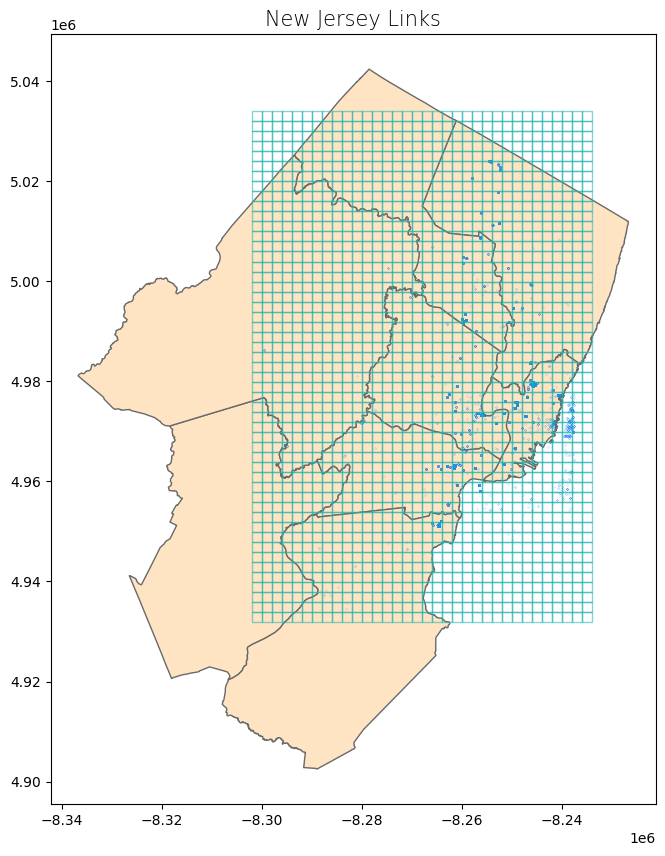

In [73]:
# Create grid
new_jersey_grid = create_grid(feature = links_nj, shape = shape, side_length = side_length)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
near_manhattan_counties = ['PASSAIC', 'BERGEN', 'ESSEX', 'HUDSON', 'UNION', 'MIDDLESEX', 'SOMERSET', 'MORRIS']
near_manhattan = nj_counties.query('COUNTY in @near_manhattan_counties')
near_manhattan.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')

links_nj.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = .001)
new_jersey_grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.55)

# Set title
ax.set_title('New Jersey Links', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [74]:
# Perform spatial join, merging attribute table of wells point and that of the cell with which it intersects
# op = "intersects" also counts those that fall on a cell boundary (between two cells)
# op = "within" will not count those fall on a cell boundary
links_nj_cell = gpd.sjoin(links_nj, new_jersey_grid, how = "inner", op = "intersects")

# Set field name to hold count value
count_field = "Count"

# Remove duplicate counts
# With intersect, those that fall on a boundary will be allocated to all cells that share that boundary
links_nj_cell = links_nj_cell.drop_duplicates(subset = ['callsign']).reset_index(drop = True)

# Add a field with constant value of 1
links_nj_cell[count_field] = 1

# Group GeoDataFrame by cell while aggregating the Count values
links_nj_cell = links_nj_cell.groupby('Grid_ID').agg({count_field:'sum'})

# Merge the resulting grouped dataframe with the grid GeoDataFrame, using a left join to keep all cell polygons
nj_grid = new_jersey_grid.merge(links_nj_cell, on = 'Grid_ID', how = "left")

# Fill the NaN values (cells without any points) with 0
nj_grid[count_field] = nj_grid[count_field].fillna(0)

# Convert Count field to integer
nj_grid[count_field] = nj_grid[count_field].astype(int)

# Display grid attribute table
display(nj_grid.head())

/home/vagrant/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


geometry  Grid_ID  Count
0  POLYGON ((-8300011.218 4931929.536, -8300011.2...        0      0
1  POLYGON ((-8300011.218 4933929.536, -8300011.2...        1      0
2  POLYGON ((-8300011.218 4935929.536, -8300011.2...        2      0
3  POLYGON ((-8300011.218 4937929.536, -8300011.2...        3      0
4  POLYGON ((-8300011.218 4939929.536, -8300011.2...        4      0

Text(0.5, 1.0, 'US Grid Link Frequency')

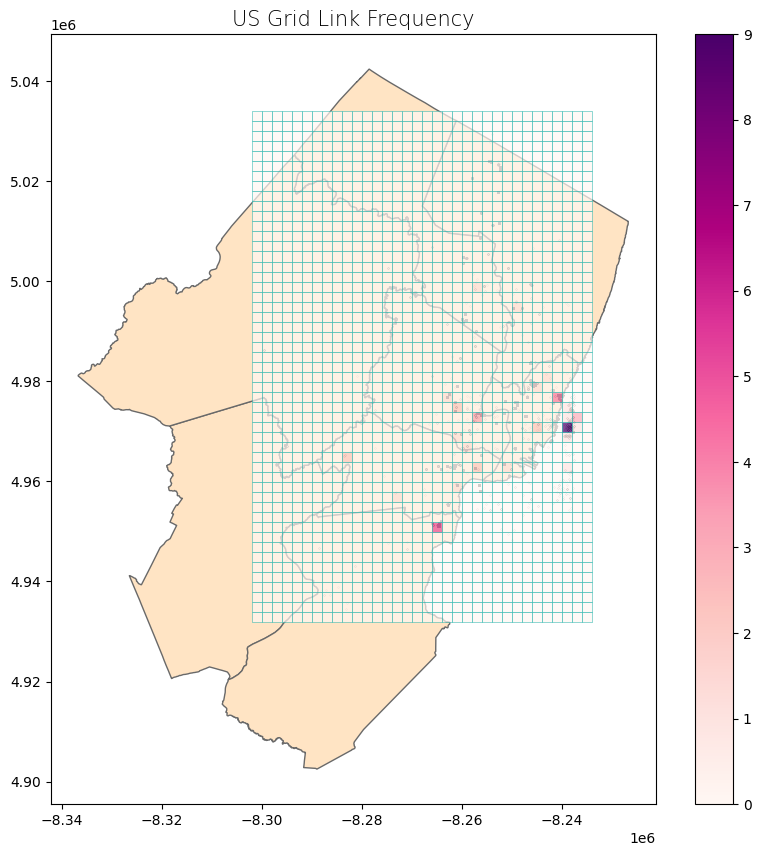

In [75]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Plot data
near_manhattan.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
links_nj.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = .001)
nj_grid.plot(ax = ax, column = "Count", cmap = "RdPu", edgecolor = 'lightseagreen', linewidth = 0.5, alpha = 0.70, legend = True)

# Set title
ax.set_title('US Grid Link Frequency', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [77]:
nj_grid = nj_grid.to_crs("EPSG:4269")
importants = nj_grid[nj_grid['Count'] > 5]['geometry']
print(nj_grid[nj_grid['Count'] > 5]['Count'])

print(importants)
for important in importants:
	print(important.centroid)

1600    9
Name: Count, dtype: int64
1600    POLYGON ((-74.00331 40.71183, -74.00331 40.725...
Name: geometry, dtype: geometry
POINT (-74.01229703088546 40.71864133613981)


In [78]:
import numpy as np

def closestDistanceBetweenLines(a0,a1,b0,b1,clampAll=False,clampA0=False,clampA1=False,clampB0=False,clampB1=False):

    ''' Given two lines defined by numpy.array pairs (a0,a1,b0,b1)
        Return the closest points on each segment and their distance
    '''

    # If clampAll=True, set all clamps to True
    if clampAll:
        clampA0=True
        clampA1=True
        clampB0=True
        clampB1=True


    # Calculate denomitator
    A = a1 - a0
    B = b1 - b0
    magA = np.linalg.norm(A)
    magB = np.linalg.norm(B)
    
    _A = A / magA
    _B = B / magB
    
    cross = np.cross(_A, _B);
    denom = np.linalg.norm(cross)**2
    
    
    # If lines are parallel (denom=0) test if lines overlap.
    # If they don't overlap then there is a closest point solution.
    # If they do overlap, there are infinite closest positions, but there is a closest distance
    if not denom:
        d0 = np.dot(_A,(b0-a0))
        
        # Overlap only possible with clamping
        if clampA0 or clampA1 or clampB0 or clampB1:
            d1 = np.dot(_A,(b1-a0))
            
            # Is segment B before A?
            if d0 <= 0 >= d1:
                if clampA0 and clampB1:
                    if np.absolute(d0) < np.absolute(d1):
                        return a0,b0,np.linalg.norm(a0-b0)
                    return a0,b1,np.linalg.norm(a0-b1)
                
                
            # Is segment B after A?
            elif d0 >= magA <= d1:
                if clampA1 and clampB0:
                    if np.absolute(d0) < np.absolute(d1):
                        return a1,b0,np.linalg.norm(a1-b0)
                    return a1,b1,np.linalg.norm(a1-b1)
                
                
        # Segments overlap, return distance between parallel segments
        return None,None,np.linalg.norm(((d0*_A)+a0)-b0)
        
    
    
    # Lines criss-cross: Calculate the projected closest points
    t = (b0 - a0);
    detA = np.linalg.det([t, _B, cross])
    detB = np.linalg.det([t, _A, cross])

    t0 = detA/denom;
    t1 = detB/denom;

    pA = a0 + (_A * t0) # Projected closest point on segment A
    pB = b0 + (_B * t1) # Projected closest point on segment B


    # Clamp projections
    if clampA0 or clampA1 or clampB0 or clampB1:
        if clampA0 and t0 < 0:
            pA = a0
        elif clampA1 and t0 > magA:
            pA = a1
        
        if clampB0 and t1 < 0:
            pB = b0
        elif clampB1 and t1 > magB:
            pB = b1
            
        # Clamp projection A
        if (clampA0 and t0 < 0) or (clampA1 and t0 > magA):
            dot = np.dot(_B,(pA-b0))
            if clampB0 and dot < 0:
                dot = 0
            elif clampB1 and dot > magB:
                dot = magB
            pB = b0 + (_B * dot)
    
        # Clamp projection B
        if (clampB0 and t1 < 0) or (clampB1 and t1 > magB):
            dot = np.dot(_A,(pB-a0))
            if clampA0 and dot < 0:
                dot = 0
            elif clampA1 and dot > magA:
                dot = magA
            pA = a0 + (_A * dot)

    
    return pA,pB,np.linalg.norm(pA-pB)

In [80]:
a1=np.array([13.43, 21.77])
a0=np.array([27.83, 31.74])
b0=np.array([77.54, 7.53])
b1=np.array([26.99, 12.39])

closestDistanceBetweenLines(a0,a1,b0,b1,clampAll=True)
closestDistanceBetweenLines(a0,a1,b0,b1,clampAll=False)

/home/vagrant/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:2149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asarray(a)


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional